In [1]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import networkx as nx
import os  
import ast #to convert the string into dict
from datetime import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

## We focus on March and we select the iptcTag 'Politique'

In [2]:
df = pd.read_csv('C:/Users/laura.finarell/OneDrive - HESSO/Polarizzazione/Code_Laura/pipeline/Dataset_User_Articles_all.csv',usecols=['User_IP','escenicID','Access_date','iptcTags','userNeeds'],index_col=[0])

In [3]:
#delete rows without user needs (265)
df.dropna(subset=['userNeeds'],inplace = True)

In [4]:
df_politique= df[df['iptcTags'].str.contains('Politique', na = False)]

In [5]:
#delete duplicates
df_politique = df_politique.drop_duplicates(subset=['User_IP','escenicID'],keep='first')
df_politique.reset_index(drop=True,inplace=True)

In [6]:
#Example of customer journey for one user 
df_politique[(df_politique['User_IP'] == '00008647e7db2f6f930813c20026d377') & (df_politique['Access_date'].str.contains('2023-03-20'))].sort_values('Access_date')

,User_IP,Access_date,escenicID,iptcTags,userNeeds
460105,00008647e7db2f6f930813c20026d377,2023-03-20 11:20:30,13874595.0,"['Politique', 'Relations internationales', 'Co...","{'UPDATE': 'principal', 'ANALYSIS': 'secondaire'}"
490476,00008647e7db2f6f930813c20026d377,2023-03-20 19:58:26,13875187.0,"['Économie et finances', 'Banque', 'Services',...",{'UPDATE': 'principal'}


In [6]:
#the dictionary is reversed --> now we have principal/secondaire as keys
dict_column = []
for i in range(0,df_politique.shape[0]):
    inv_map = dict(zip(ast.literal_eval(df_politique['userNeeds'][i]).values(), ast.literal_eval(df_politique['userNeeds'][i]).keys()))
    dict_column.append(inv_map)

In [7]:
df_politique['userNeeds_dict'] = dict_column

In [8]:
df_politique.drop(['userNeeds'],axis = 1,inplace=True)

In [9]:
userNeed = []
for i in range(0,df_politique.shape[0]):
    userNeed.append(df_politique['userNeeds_dict'][i].get('principal'))

In [10]:
df_politique['userNeed'] = userNeed

In [11]:
df_politique.drop(['userNeeds_dict'],axis = 1,inplace=True)

In [12]:
df_politique['date'] = df_politique['Access_date'].str[:10]

In [13]:
#For each user and each day we have the customer journey
df_journey = df_politique.groupby(['User_IP','date'])['userNeed'].agg(lambda x: x ).reset_index(name='Customer_journey')

In [14]:
df_journey.head()

,User_IP,date,Customer_journey
0,000032eb86b057bb71971114b32ae90b,2023-03-04,TREND
1,00008647e7db2f6f930813c20026d377,2023-03-20,"[UPDATE, UPDATE]"
2,0000d15ebdea3c99cd2793d260887ff9,2023-03-05,ANALYSIS
3,0000f3584ef7a663ff605d9bfdd23fbc,2023-03-01,"[ANALYSIS, UPDATE, UPDATE, ANALYSIS]"
4,0000f3584ef7a663ff605d9bfdd23fbc,2023-03-02,"[UPDATE, UPDATE, UPDATE]"


In [18]:
#We clean the customer journey such that we don't have two equal UN adiacent
def dedupe_adjacent(iterable):
    prev = object()
    for item in iterable:
         if item != prev:
             prev = item
             yield item

In [15]:
#convert everything into string because if only one is a string, if more an array
for i in range(0,df_journey.shape[0]):
    df_journey.loc[i,'Customer_journey'] = str(df_journey.loc[i,'Customer_journey'])

In [16]:
df_journey['Customer_journey']

0                                             TREND
1                               ['UPDATE' 'UPDATE']
2                                          ANALYSIS
3         ['ANALYSIS' 'UPDATE' 'UPDATE' 'ANALYSIS']
4                      ['UPDATE' 'UPDATE' 'UPDATE']
                            ...                    
544003                                     ANALYSIS
544004                        ['ANALYSIS' 'UPDATE']
544005                                     ANALYSIS
544006                          ['UPDATE' 'UPDATE']
544007                                     ANALYSIS
Name: Customer_journey, Length: 544008, dtype: object

In [17]:
#THERE is NO pattern with only 1 UN
df_journey = df_journey[df_journey['Customer_journey'].str.contains("\[\'")]

In [18]:
df_journey.to_csv('Customer_Journey_Politique_March.csv')

In [18]:
df_journey[df_journey['Customer_journey'].str.contains("ANALYSIS|EDUCATE")]

,User_IP,date,Customer_journey
3,0000f3584ef7a663ff605d9bfdd23fbc,2023-03-01,['ANALYSIS' 'UPDATE' 'UPDATE' 'ANALYSIS']
7,0000f3584ef7a663ff605d9bfdd23fbc,2023-03-05,['ANALYSIS' 'UPDATE' 'INSPIRE' 'UPDATE' 'ANALY...
9,0000f3584ef7a663ff605d9bfdd23fbc,2023-03-07,['UPDATE' 'UPDATE' 'UPDATE' 'UPDATE' 'UPDATE' ...
13,0000f3584ef7a663ff605d9bfdd23fbc,2023-03-11,['UPDATE' 'UPDATE' 'UPDATE' 'UPDATE' 'ANALYSIS']
18,0000f3584ef7a663ff605d9bfdd23fbc,2023-03-21,['ANALYSIS' 'UPDATE' 'UPDATE']
...,...,...,...
543973,fffe54d9fe7535c954141ff2056edd49,2023-03-03,['ANALYSIS' 'ANALYSIS']
543984,fffe75a8722c69ae1c5311a136e4ab0a,2023-03-02,['ANALYSIS' 'UPDATE']
543995,fffe75a8722c69ae1c5311a136e4ab0a,2023-03-23,['ANALYSIS' 'ANALYSIS' 'ANALYSIS' 'UPDATE']
543997,fffe75a8722c69ae1c5311a136e4ab0a,2023-03-25,['UPDATE' 'ANALYSIS']


In [19]:
df_allUN_per_user = df_journey.groupby('User_IP')['Customer_journey'].apply(lambda x: ', '.join(x)).reset_index()

In [20]:
df_allUN_per_user

,User_IP,Customer_journey
0,00008647e7db2f6f930813c20026d377,['UPDATE' 'UPDATE']
1,0000f3584ef7a663ff605d9bfdd23fbc,"['ANALYSIS' 'UPDATE' 'UPDATE' 'ANALYSIS'], ['U..."
2,00017da0eff04d2323afc415aa2be79b,"['UPDATE' 'UPDATE' 'UPDATE'], ['UPDATE' 'UPDAT..."
3,0001fd42e58c64a5b0d2556fe9705a1b,['UPDATE' 'UPDATE']
4,00026db8e2ac9446a63eed1d73cab9d3,['INSPIRE' 'ANALYSIS']
...,...,...
68418,fffe54d9fe7535c954141ff2056edd49,"['ANALYSIS' 'UPDATE'], ['ANALYSIS' 'ANALYSIS']..."
68419,fffe75a8722c69ae1c5311a136e4ab0a,"['ANALYSIS' 'UPDATE'], ['TREND' 'UPDATE'], ['U..."
68420,ffff05e23fe242d5c3babac2d135f3bf,['UPDATE' 'UPDATE']
68421,ffff89283632bf0b8f2c6343f97634e2,['ANALYSIS' 'UPDATE']


In [76]:
# List of user needs to count
user_needs_to_count = ['ANALYSIS', 'UPDATE', 'EDUCATE', 'INSPIRE', 'TREND']

# Function to count occurrences of each user need
def count_user_needs(user_needs_str):
    user_needs_list = ast.literal_eval(user_needs_str)
    counts = {need: 0 for need in user_needs_to_count}  # Initialize counts dictionary
    for need in user_needs_to_count:
        count = user_needs_str.count(need)
        counts[need] = count
    return counts

In [77]:
df_allUN_per_user['count_of_user_needs'] = df_allUN_per_user['Customer_journey'].apply(count_user_needs)

In [81]:
df_counts = df_allUN_per_user['Customer_journey'].apply(count_user_needs).apply(pd.Series)

In [83]:
df_UN_frequency_per_user = pd.concat([df_allUN_per_user, df_counts], axis=1)

In [85]:
df_UN_frequency_per_user.to_csv('UN_frequency_per_user_politique.csv',index='False')

## Clustering

In [134]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_counts)

Compute Mean and Standard Deviation: For each feature (column) in the dataset, StandardScaler computes the mean and standard deviation.
Standardization: It then subtracts the mean from each feature and divides by the standard deviation, effectively scaling each feature to have a mean of 0 and a standard deviation of 1.

In [135]:
df_scaled = pd.DataFrame(df_scaled, columns=df_counts.columns)

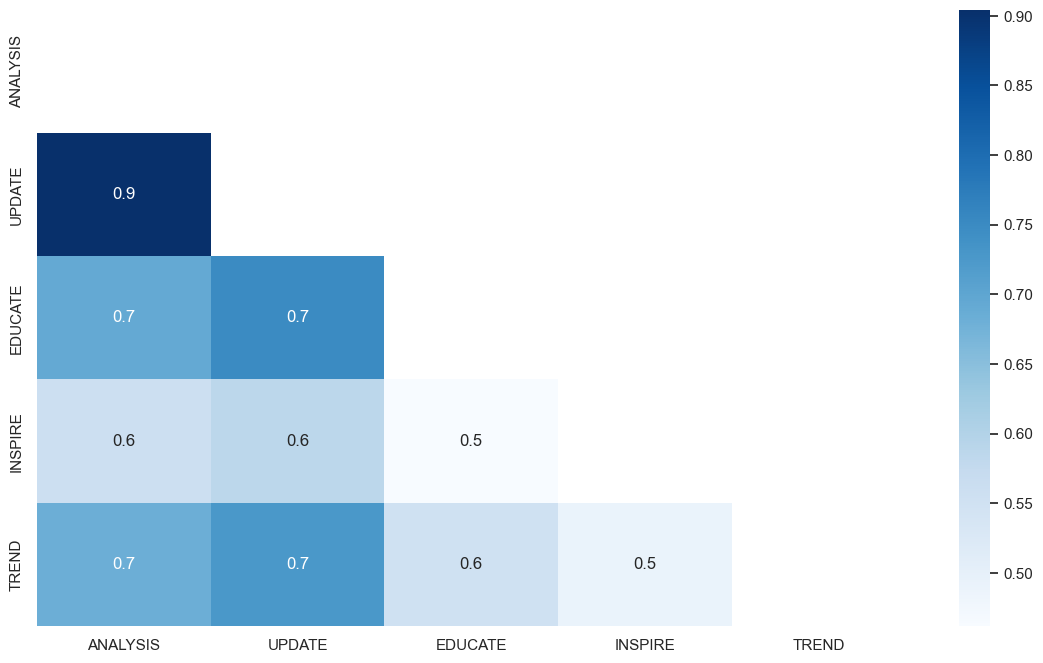

In [119]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_scaled.corr()
mask = np.triu(df_scaled.corr())
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g',mask=mask)

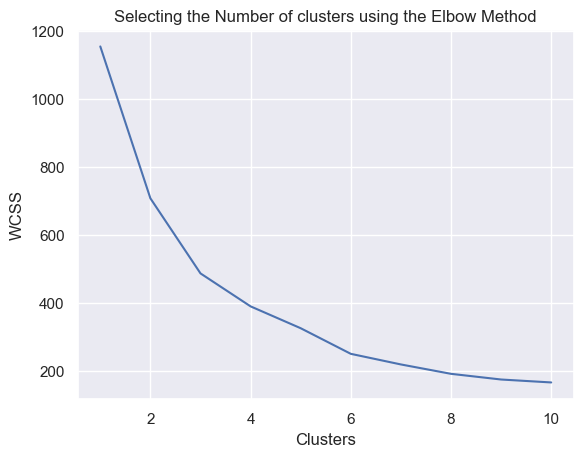

In [120]:
# We use the elbow method to find the best number of clusters
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state =0,n_init='auto')
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)  #within cluster sum of squares
    sns.set()
plt.plot(range(1,11),wcss)
plt.title('Selecting the Number of clusters using the Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()

In [155]:
kmeans = KMeans(n_clusters=3,n_init='auto')
kmeans.fit(df_scaled)

KMeans(n_clusters=3, n_init='auto')

In [130]:
df_scaled['labels'] = kmeans.labels_

In [131]:
df_scaled

,ANALYSIS,UPDATE,EDUCATE,INSPIRE,TREND,labels
0,0.000000,0.009950,0.0,0.0,0.000000,1
1,0.160714,0.278607,0.0,0.4,0.333333,0
2,0.071429,0.034826,0.0,0.0,0.000000,1
3,0.000000,0.009950,0.0,0.0,0.000000,1
4,0.017857,0.000000,0.0,0.2,0.000000,0
...,...,...,...,...,...,...
68418,0.053571,0.034826,0.0,0.0,0.000000,1
68419,0.089286,0.099502,0.0,0.0,0.083333,1
68420,0.000000,0.009950,0.0,0.0,0.000000,1
68421,0.017857,0.004975,0.0,0.0,0.000000,1


In [156]:
#extracting centers
centers = kmeans.cluster_centers_
df_center = pd.DataFrame(centers,columns = user_needs_to_count)

In [157]:
df_center = df_center.applymap(lambda x: 0 if x < 0 else x)

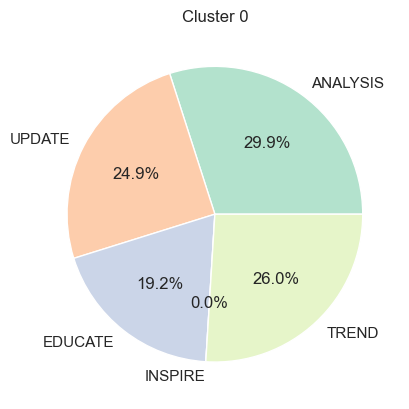

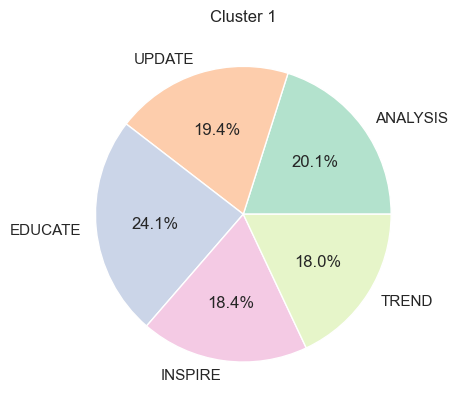

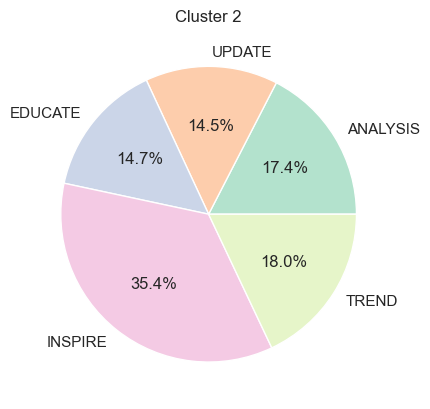

In [158]:
for i in range(df_center.shape[0]):
    plt.figure()
    values = df_center.loc[i,:].values
    plt.pie(values, labels=df_center.columns, autopct='%1.1f%%', colors=plt.cm.Pastel2.colors)
    plt.title('Cluster ' + str(i))
    plt.show()